<a href="https://colab.research.google.com/github/Aasha03/AquaMap/blob/main/water_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


parent_folder_path = '/content/drive/MyDrive/water'

#resizing and  augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #to be fixed
])


dataset = ImageFolder(root=parent_folder_path, transform=transform)

In [ ]:
from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

#ResNet-18 model
model = models.resnet18(pretrained=True)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s] 


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
batch_size = 32
learning_rate = 0.001
num_epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/10, Loss: 1.185291051864624
Epoch 2/10, Loss: 0.8529743875066439
Epoch 3/10, Loss: 0.6020791654785475
Epoch 4/10, Loss: 0.4170495371023814
Epoch 5/10, Loss: 0.4054178483784199
Epoch 6/10, Loss: 0.25558433557550114
Epoch 7/10, Loss: 0.30670688425501186
Epoch 8/10, Loss: 0.2724272434910138
Epoch 9/10, Loss: 0.21142686530947685
Epoch 10/10, Loss: 0.2144346789767345


In [ ]:
model.eval()
correct_val, correct_test = 0, 0
total_val, total_test = 0, 0

# Validation set evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

# Test set evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# accuracy
val_accuracy = correct_val / total_val * 100
test_accuracy = correct_test / total_test * 100

print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Validation Accuracy: 70.89%
Test Accuracy: 72.50%


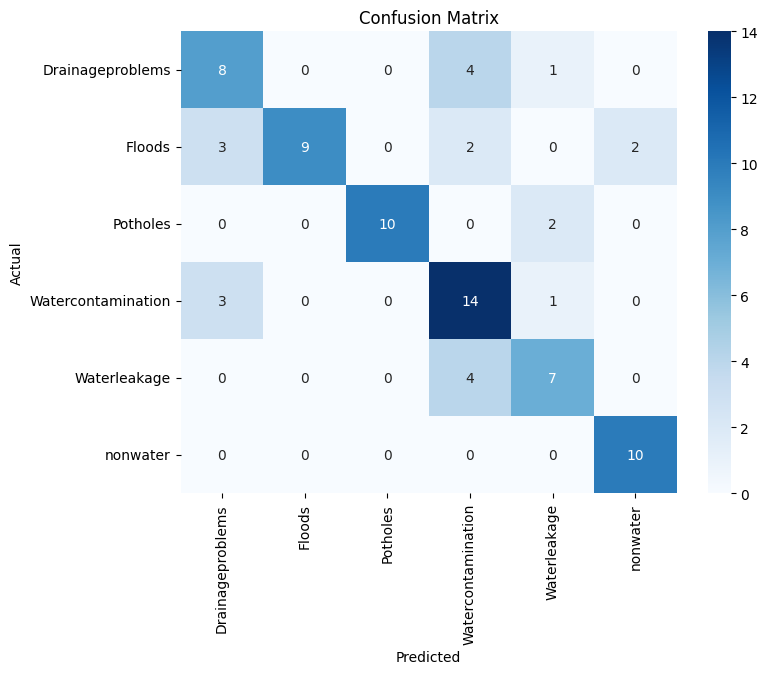

                    precision    recall  f1-score   support

  Drainageproblems       0.57      0.62      0.59        13
            Floods       1.00      0.56      0.72        16
          Potholes       1.00      0.83      0.91        12
Watercontamination       0.58      0.78      0.67        18
      Waterleakage       0.64      0.64      0.64        11
          nonwater       0.83      1.00      0.91        10

          accuracy                           0.73        80
         macro avg       0.77      0.74      0.74        80
      weighted avg       0.77      0.72      0.73        80



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    all_predicted = []
    all_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predicted = np.array(all_predicted)
all_labels = np.array(all_labels)

#confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)

#heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# classification report
report = classification_report(all_labels, all_predicted, target_names=dataset.classes)
print(report)